In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm 

%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import skew
from math import sqrt

# plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from subprocess import check_output
print(check_output(["ls", "Data"]).decode("utf8"))

data_description.txt
sample_submission.csv
test.csv
train.csv



In [2]:
# setting the number of cross validations used in the Model part 
nr_cv = 5

# switch for using log values for SalePrice and features     
use_logvals = 1    
# target used for correlation 
target = 'SalePrice_Log'
    
# only columns with correlation above this threshold value  
# are used for the ML Regressors in Part 3
min_val_corr = 0.39    
    
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

In [3]:
# def get_best_score(grid):
    
#     best_score = np.sqrt(-grid.best_score_)
#     print(best_score)    
#     print(grid.best_params_)
#     print(grid.best_estimator_)
    
#     return best_score

# def print_cols_large_corr(df, nr_c, targ) :
#     corr = df.corr()
#     corr_abs = corr.abs()
#     print (corr_abs.nlargest(nr_c, targ)[targ])
    
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

In [4]:
df_train = pd.read_csv("Data/train.csv")
df_test = pd.read_csv("Data/test.csv")
print(df_train.shape)
print(df_test.shape)

(1460, 81)
(1459, 80)


In [5]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

# Missingness & Imputation

In [6]:
total1 = df_train.isnull().sum().sort_values(ascending=False)
percent1 = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data1 = pd.concat([total1, percent1], axis=1, keys=['Total', 'Percent'])
missing_data1.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [7]:
total2 = df_test.isnull().sum().sort_values(ascending=False)
percent2 = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data2 = pd.concat([total2, percent2], axis=1, keys=['Total', 'Percent'])
missing_data2.head(35)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461


In [8]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_train[col].fillna('None',inplace=True)
    df_test[col].fillna('None',inplace=True)

In [9]:
total2 = df_test.isnull().sum().sort_values(ascending=False)
percent2 = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data2 = pd.concat([total2, percent2], axis=1, keys=['Total', 'Percent'])
missing_data2.head(15)
missing_data2.head(11).index

Index(['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BsmtFullBath',
       'BsmtHalfBath', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFinSF1',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [10]:
# fillna with median for the remaining columns: GarageYrBlt
cols_fillna_median = ['LotFrontage', 'GarageYrBlt']
cols_fillna_0 = ['MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFinSF1',
       'GarageCars', 'GarageArea']

for col in cols_fillna_median:
    df_train[col].fillna(df_train[col].median(),inplace=True)
    df_test[col].fillna(df_test[col].median(),inplace=True)
    
for col in cols_fillna_0:
    df_train[col].fillna(0, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [11]:
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())

0
0


# Features Creation & Transformation

In [12]:
for df in [df_train, df_test]:
    # features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

    df['YrBltAndRemod']=df['YearBuilt']+df['YearRemodAdd']
    df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    df['Total_sqr_footage'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] +
                                      df['1stFlrSF'] + df['2ndFlrSF'])

    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                                    df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

    df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                                   df['EnclosedPorch'] + df['ScreenPorch'] +
                                   df['WoodDeckSF'])

In [13]:
for df in [df_train, df_test]:
    df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [14]:
print(df_train.shape)
print(df_test.shape)

(1460, 91)
(1459, 90)


In [15]:
# df_train.describe().transpose()
# df_train.describe(include = ['O']).transpose()
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  48
Number of Categorical features:  43


In [16]:
for col in numerical_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt())  
         )

Id              Skewness: 00.00     Kurtosis: -01.20
MSSubClass      Skewness: 01.41     Kurtosis: 001.58
LotFrontage     Skewness: 02.41     Kurtosis: 021.91
LotArea         Skewness: 12.21     Kurtosis: 203.24
OverallQual     Skewness: 00.22     Kurtosis: 000.10
OverallCond     Skewness: 00.69     Kurtosis: 001.11
YearBuilt       Skewness: -0.61     Kurtosis: -00.44
YearRemodAdd    Skewness: -0.50     Kurtosis: -01.27
MasVnrArea      Skewness: 02.68     Kurtosis: 010.14
BsmtFinSF1      Skewness: 01.69     Kurtosis: 011.12
BsmtFinSF2      Skewness: 04.26     Kurtosis: 020.11
BsmtUnfSF       Skewness: 00.92     Kurtosis: 000.47
TotalBsmtSF     Skewness: 01.52     Kurtosis: 013.25
1stFlrSF        Skewness: 01.38     Kurtosis: 005.75
2ndFlrSF        Skewness: 00.81     Kurtosis: -00.55
LowQualFinSF    Skewness: 09.01     Kurtosis: 083.23
GrLivArea       Skewness: 01.37     Kurtosis: 004.90
BsmtFullBath    Skewness: 00.60     Kurtosis: -00.84
BsmtHalfBath    Skewness: 04.10     Kurtosis: 

Skewness: 0.121335
Kurtosis: 0.809532


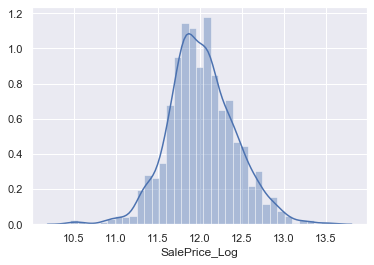

In [17]:
df_train['SalePrice_Log'] = np.log(df_train['SalePrice'])

sns.distplot(df_train['SalePrice_Log']);
# skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice_Log'].skew())
print("Kurtosis: %f" % df_train['SalePrice_Log'].kurt())
# dropping old column
# df_train.drop('SalePrice', axis= 1, inplace=True)

In [18]:
df_train.corr().abs()[['SalePrice','SalePrice_Log']].sort_values(by='SalePrice', ascending=False)

,SalePrice,SalePrice_Log
SalePrice,1.000000,0.948374
SalePrice_Log,0.948374,1.000000
OverallQual,0.790982,0.817184
TotalSF,0.782260,0.777296
GrLivArea,0.708624,0.700927
Total_sqr_footage,0.708047,0.698492
GarageCars,0.640409,0.680625
Total_Bathrooms,0.631731,0.673011
GarageArea,0.623431,0.650888
TotalBsmtSF,0.613581,0.612134


In [19]:
for df in [df_train, df_test]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    #df.drop('GrLivArea', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    #df.drop('LotArea', inplace= True, axis = 1)
    df['TotalSF_log'] = np.log(df['TotalSF'])
    df['Total_sqr_footage_log'] = np.log(df['Total_sqr_footage'])
    
    
    
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index

In [20]:
df_test[df_test['Total_sqr_footage'] == 0]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,GrLivArea_Log,LotArea_Log,TotalSF_log,Total_sqr_footage_log


In [21]:
df_test[df_test['TotalSF'] == 0]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,GrLivArea_Log,LotArea_Log,TotalSF_log,Total_sqr_footage_log


In [22]:
df_corr = df_train.corrwith(df_train['SalePrice']).abs().sort_values(ascending=False)[2:]

data = go.Bar(x=df_corr.index, 
              y=df_corr.values )
       
layout = go.Layout(title = 'Correlation to Sale Price', 
                   xaxis = dict(title = ''), 
                   yaxis = dict(title = 'correlation'),
                   autosize=False, width=750, height=500,)

fig = dict(data = [data], layout = layout)
iplot(fig)

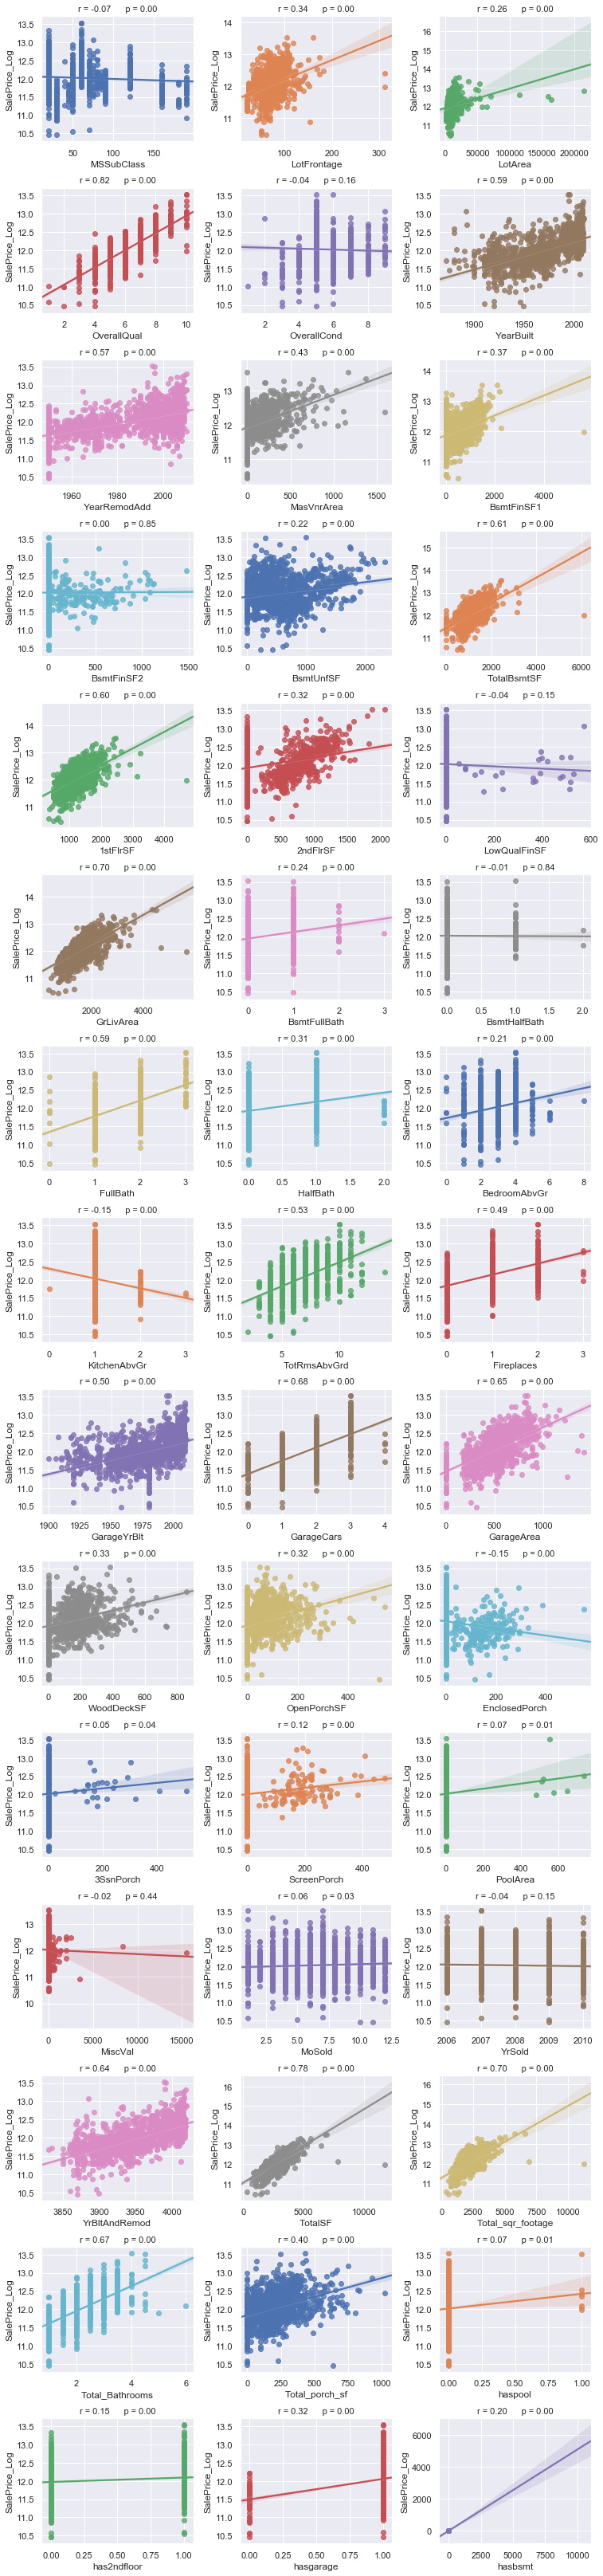

In [23]:
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()

In [24]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  53
Number of Categorical features:  43


In [25]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [26]:
print(cols_abv_corr_limit)
print(len(cols_abv_corr_limit))
print(cols_bel_corr_limit)
print(len(cols_bel_corr_limit))
ser_corr

['SalePrice_Log', 'SalePrice', 'OverallQual', 'TotalSF_log', 'TotalSF', 'Total_sqr_footage_log', 'GrLivArea_Log', 'GrLivArea', 'Total_sqr_footage', 'GarageCars', 'Total_Bathrooms', 'GarageArea', 'YrBltAndRemod', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 'hasfireplace', 'GarageYrBlt', 'Fireplaces', 'MasVnrArea', 'LotArea_Log', 'Total_porch_sf']
25
['BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'hasgarage', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'hasbsmt', 'has2ndfloor', 'EnclosedPorch', 'KitchenAbvGr', 'ScreenPorch', 'MSSubClass', 'haspool', 'PoolArea', 'MoSold', '3SsnPorch', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MiscVal', 'Id', 'BsmtHalfBath', 'BsmtFinSF2']
28


SalePrice_Log            1.000000
SalePrice                0.948374
OverallQual              0.817184
TotalSF_log              0.807124
TotalSF                  0.777296
Total_sqr_footage_log    0.741062
GrLivArea_Log            0.730255
GrLivArea                0.700927
Total_sqr_footage        0.698492
GarageCars               0.680625
Total_Bathrooms          0.673011
GarageArea               0.650888
YrBltAndRemod            0.644833
TotalBsmtSF              0.612134
1stFlrSF                 0.596981
FullBath                 0.594771
YearBuilt                0.586570
YearRemodAdd             0.565608
TotRmsAbvGrd             0.534422
hasfireplace             0.510026
GarageYrBlt              0.495794
Fireplaces               0.489449
MasVnrArea               0.426775
LotArea_Log              0.399918
Total_porch_sf           0.398387
BsmtFinSF1               0.372023
LotFrontage              0.335292
WoodDeckSF               0.334135
hasgarage                0.322999
OpenPorchSF   

In [27]:
# nr_feats = len(cols_abv_corr_limit)
# plot_corr_matrix(df_train, nr_feats, target)

In [28]:
catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]

In [29]:
print(len(catg_strong_corr))
print(len(catg_weak_corr))

10
33


In [30]:
# nr_feats=len(df_train.columns)
# plot_corr_matrix(df_train, nr_feats, target)

In [31]:
catg_list = catg_strong_corr.copy()
catg_list.remove('Neighborhood')

# for catg in catg_list :
#     #sns.catplot(x=catg, y=target, data=df_train, kind='boxen')
#     sns.violinplot(x=catg, y=target, data=df_train)
#     plt.show()
#     #sns.boxenplot(x=catg, y=target, data=df_train)
#     #bp = df_train.boxplot(column=[target], by=catg)

In [32]:
# fig, ax = plt.subplots()
# fig.set_size_inches(16, 5)
# sns.violinplot(x='Neighborhood', y=target, data=df_train, ax=ax)
# plt.xticks(rotation=45)
# plt.show()

In [33]:
# for catg in catg_list :
#     g = df_train.groupby(catg)[target].mean()
#     print(g)

In [34]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']

In [35]:
for df in [df_train, df_test]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4  
  

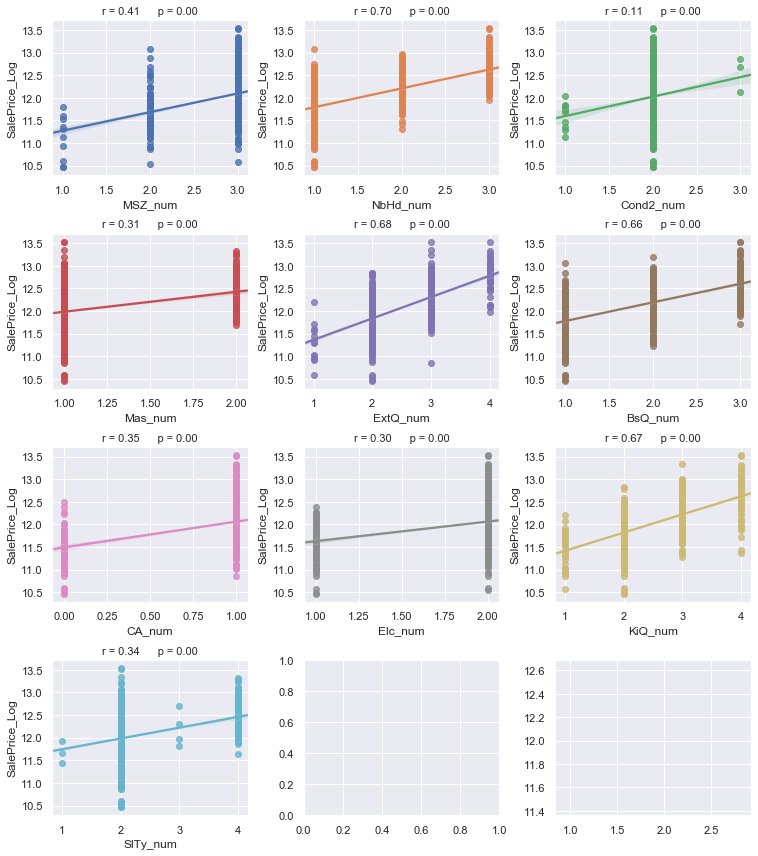

In [36]:
new_col_num = ['MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']

nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(new_col_num):
            sns.regplot(df_train[new_col_num[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[new_col_num[i]], df_train[target])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

In [44]:
cols_bel_corr_limit

['BsmtFinSF1',
 'LotFrontage',
 'WoodDeckSF',
 'hasgarage',
 'OpenPorchSF',
 '2ndFlrSF',
 'HalfBath',
 'LotArea',
 'BsmtFullBath',
 'BsmtUnfSF',
 'BedroomAbvGr',
 'hasbsmt',
 'has2ndfloor',
 'EnclosedPorch',
 'KitchenAbvGr',
 'ScreenPorch',
 'MSSubClass',
 'haspool',
 'PoolArea',
 'MoSold',
 '3SsnPorch',
 'LowQualFinSF',
 'YrSold',
 'OverallCond',
 'MiscVal',
 'Id',
 'BsmtHalfBath',
 'BsmtFinSF2']

In [47]:
categorical_feats.tolist()

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [48]:
# Drop columns
id_test = df_test['Id']

to_drop_num  = cols_bel_corr_limit
to_drop_catg = categorical_feats.tolist()
to_drop_mul = ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt', 'FullBath', 'YearBuilt', 
               'YearRemodAdd', 'GrLivArea', 'LotArea', 'TotalSF', 'Total_sqr_footage', 'Fireplaces']

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg + to_drop_mul

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)
    
df_train.drop('SalePrice', axis= 1, inplace=True)

In [51]:
to_drop_dum = ['Cond2_num', 'Mas_num', 'CA_num', 'Elc_num', 'SlTy_num']

for df in [df_train, df_test]:
    df.drop(to_drop_dum, inplace= True, axis = 1)

In [52]:
print(df_train.shape)
print(df_test.shape)

(1460, 19)
(1459, 18)


In [ ]:
# num = df_train.dtypes[df_train.dtypes != "object"].index
# print("Number of Numerical features: ", len(num))

# cat = df_train.dtypes[df_train.dtypes == "object"].index
# print("Number of Categorical features: ", len(cat))

In [53]:
df_train.to_csv('./train3.csv', index=False)
df_test.to_csv('./test3.csv', index=False)